# Analysis of Prelec, Seung, McCoy 2017

Prelec, Dražen, H.Sebastian Seung, and John McCoy. 2017. “A Solution to the Single-Question Crowd Wisdom Problem.” Nature 541(7638):532–35. 

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import networkx as nx
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Because the paper assumes that individuals know what people would vote in each plausible world, each individual is (in effect) asked the question:

- are we in world A, where the fact is true and 90% of the people think so
- are we in world B, where the fact is false, but 60% of the people think it is true
    

The algorithm then goes something like:
    
    In world A:
    votes for A are predicted to be seen in:
    predicted = .9 * .9 + (1-.9) * .6 = .87
    
    But we observe:
    observed = .9
    so A is is a surprisingly popular opinion.

And if the counterfactual world was true:

    In world B: 
    votes for A are predicted to be seen in:
    predicted = .4 * .6 + .6 * .9 = .78
    
    But we observe
    observed = .6
    so B is a surprisingly popular opinion
    
Generally, take a weighted average of the two beliefs about how many people will vote A, if more than that many do, then A is likely to be true, if fewer, then B is likely to be true.

    measure = (fraction voting A) * (fraction of people that A voters expect to vote A) + 
              (fraction voting B) * (fraction of people that B voters expect to vote A)
             


Relaxing the assumption that voters have correct beliefs about what people would vote for in either world - ie, assume real humans, then you could be anywhere in a 3d space of "Actual Votes", "**A voters'** belief about the fraction voting for **A**", and "**B voters'** belief about the fraction voting for **A**". Here take a slice at fixed actual vote.

The weighted average is different at every point in the space. The algorithm will predict A when you the world corresponds to a point in the space below the value for the actual vote, in this case 0.6.

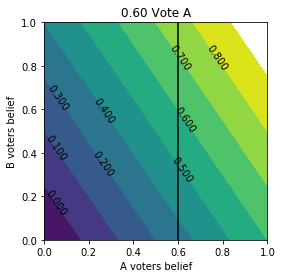

In [2]:
plt.figure(figsize=(4,4))
A_f_As = np.linspace(0,1,100)
B_f_As = np.linspace(0,1,100)
f_A = .6

A_f_Ag, B_f_Ag = np.meshgrid(A_f_As, B_f_As)
measures = f_A * A_f_Ag + (1-f_A) * B_f_Ag

levels = np.arange(0,1,.1)
CS = plt.contourf(A_f_Ag, B_f_Ag, measures, levels )
plt.clabel(CS, inline=1, fontsize=10, colors='k')
plt.vlines(f_A, 0, 1)
plt.title('%.02f Vote A' % f_A)
plt.xlabel('A voters belief')
plt.ylabel('B voters belief');

In the below figure, each plot corresponds to a different vote outcome. When the voters for A and B have values for their belief such that the system is below the dividing line, then the algorithm predicts outcome A. 

The vertical black line corresponds to A voters having a correct interpretation of the fraction that vote A. This crosses the threshold on the 45 degree line. What this means is that for the algorithm to predict the correct result when A voters (the correct ones) precisely estimate the fraction of correct voters, the incorrect voters must overestimate the extent to which people agree with them. This accords with the intuition that an individual may choose an option because they have domain specific knowledge, or because they have social encouragement to do so, and possibly both. But they are not likely to adopt a belief that they believe the majority of people reject, without some other proof.

If A voters overestimate their support, then B voters must also overestimate their support, the exchange rate being a function of the total number of votes actually received.

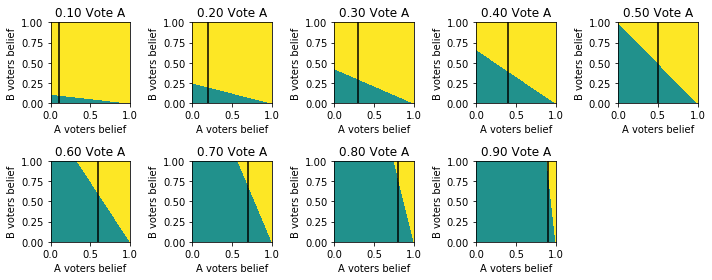

In [3]:
plt.figure(figsize=(10,4))
A_f_As = np.linspace(0,1,100)
B_f_As = np.linspace(0,1,100)

A_f_Ag, B_f_Ag = np.meshgrid(A_f_As, B_f_As)


for i, f_A in enumerate(np.arange(.1, 1, .1)):
    plt.subplot(2,5,i+1)
    measures = f_A * A_f_Ag + (1-f_A) * B_f_Ag

    levels = [0, f_A, 1]
    CS = plt.contourf(A_f_Ag, B_f_Ag, measures, levels, vmin=0, vmax=f_A )
    plt.vlines(f_A, 0, 1)
    plt.title('%.02f Vote A' % f_A)
    plt.xlabel('A voters belief')
    plt.ylabel('B voters belief')
plt.tight_layout()

# Generating Points

What sociological processes could lead to the system occupying each regime?

in order to say that most people don't agree with you, without changing your answer, you have to believe that you know most people are wrong and you are right. if your source of confidence comes from either additional information or from social support, then you might be able to generate those cases on average.

So, in our simulation, assign some random fraction to have true knowledge, (these could be clustered, perhaps), and then give the remaining a random belief state.

In [39]:
def setup(n_voters=1000, WS_k=4, WS_p=.1, 
          f_know=.1,  # what fraction of the population is given the ground truth
          initial_bias_towards=.3,  # for the remaining (uninformed) population, how likely are they to believe?
          a=0, # how much should knowledge be clustered? 0 is uniform dist...
         ):
    np.random.seed()
    g = nx.watts_strogatz_graph(n_voters, k=WS_k, p=WS_p)
    
    #cluster knowledge
    x = np.linspace(0,1,n_voters)
    y = x**a*(1-x)**a
    ps = y/sum(y)
    
    knowers = np.random.choice(range(n_voters), size=int(n_voters*f_know), replace=False, p=ps)
    have_info = [1if i in knowers else 0 for i in range(n_voters) ]
    nx.set_node_attributes(g, name='informed', values={n:i for n, i in enumerate(have_info)})

    believe = where(have_info, 1, np.random.binomial(1, initial_bias_towards, n_voters))
    nx.set_node_attributes(g, name='believe', values={n:i for n, i in enumerate(believe)})

    return g

g = setup()

Now assume that if you don't have knowledge, you poll your neighbors and choose to believe if some threshold of your friends believe. Iterate to convergence.

At the end, each agent polls their friends, and makes an assessment of how they think the average voter will vote, either including their own view or not.

In [40]:
def simulate(g, threshold=.5, max_rounds=10, include_own=False):
    f_A = np.mean([g.node[n]['believe'] for n in g])
    for i in range(max_rounds):
        for n in np.random.permutation(g):
            if g.node[n]['informed'] == 0:
                neighbors_beliefs = np.array([g.node[nb]['believe'] for nb in g[n]])
                g.node[n]['believe'] = 1 if np.mean(neighbors_beliefs) > threshold else 0
                
        new_f_A = np.mean([g.node[n]['believe'] for n in g])
        if new_f_A == f_A:  # converged
            print('Converged at %.02f after %i rounds' % (f_A, i+1))
            break
        else:
            f_A = new_f_A

    # individuals form an expectation for the fraction of their neighbors who believe
    for n in g:
        neighbors_beliefs = [g.node[nb]['believe'] for nb in g[n]]
        if include_own:
            neighbors_beliefs.append(g.node[n]['believe'])
            #print(neighbors_beliefs)
        g.node[n]['expectation believe'] = np.mean(np.array(neighbors_beliefs))
    
    return g

simulate(g, include_own=True)

Converged at 0.18 after 8 rounds


In [41]:
def measure(g):
    f_A = np.mean([g.node[n]['believe'] for n in g])
    A_f_A = np.mean([g.node[n]['expectation believe'] for n in g if g.node[n]['believe']==1])
    B_f_A = np.mean([g.node[n]['expectation believe'] for n in g if g.node[n]['believe']==0])
    
    return f_A, A_f_A, B_f_A

f_A, A_f_A, B_f_A = measure(g)

Now I'll include the actual settling point for voter's beliefs about how many other people will vote for A/believe as a star on the previous figures.

It is interesting that this star lines up exactly on the line at which the algorithm should switch from predicting A to predicting B.

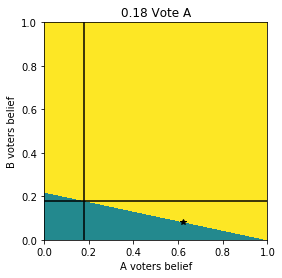

In [43]:
plt.figure(figsize=(4,4))

def plot(f_A, A_f_A, B_f_A):
    A_f_As = np.linspace(0,1,100)
    B_f_As = np.linspace(0,1,100)

    A_f_Ag, B_f_Ag = np.meshgrid(A_f_As, B_f_As)
    measures = f_A * A_f_Ag + (1-f_A) * B_f_Ag

    levels = [-0.01, f_A, 1.01]
    CS = plt.contourf(A_f_Ag, B_f_Ag, measures, levels, vmin=0, vmax=f_A )

    plt.vlines(f_A, 0, 1)
    plt.hlines(f_A, 0, 1)

    plt.plot(A_f_A, B_f_A, 'k*')

    plt.title('%.02f Vote A' % f_A)
    plt.xlabel('A voters belief')
    plt.ylabel('B voters belief');
    
plot(f_A, A_f_A, B_f_A)

This doesn't seem to be a property of the dynamics, just a property of the way people measure the state around them. Trying 25 different networks, likelihoods of knowledge, or initial bias, all without running the convergence algorithm (so the beliefs are themselves all scattered throughout the population) yields the same result:

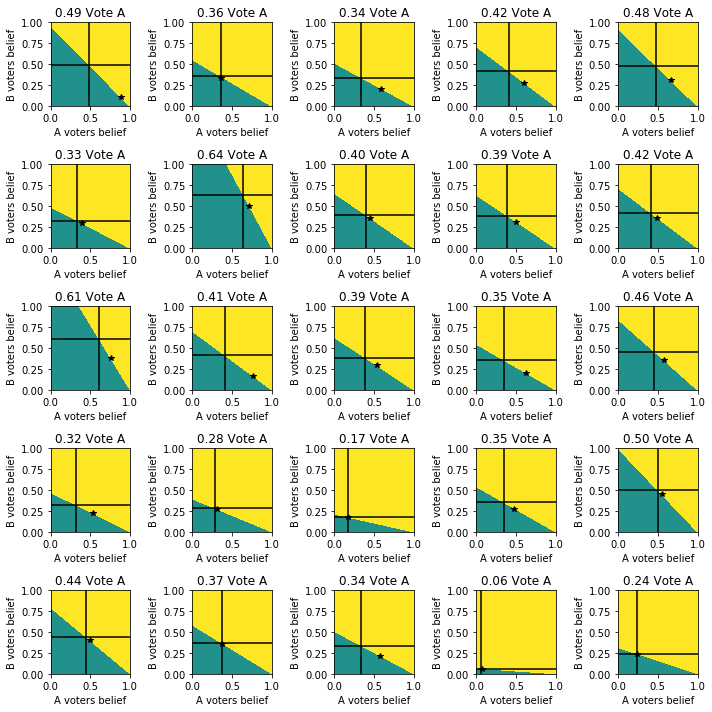

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup(WS_p=np.random.uniform(0,.3), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4))
    g = simulate(g, max_rounds=0)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

As does having all of the 'knowledge' clustered in one part of the ring lattice

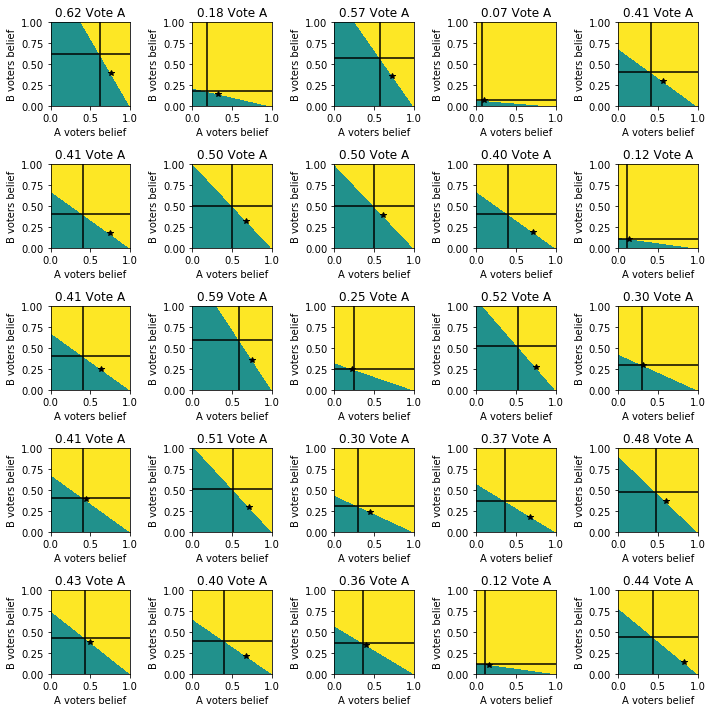

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup(WS_p=np.random.uniform(0,.3), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4), a=10)
    g = simulate(g, max_rounds=0)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

Even when we allow them all to go to equilibrium:

Converged at 0.01 after 2 rounds
Converged at 0.15 after 5 rounds
Converged at 0.14 after 7 rounds
Converged at 0.34 after 5 rounds
Converged at 0.44 after 5 rounds
Converged at 0.48 after 6 rounds
Converged at 0.33 after 3 rounds
Converged at 0.52 after 5 rounds
Converged at 0.32 after 6 rounds
Converged at 0.45 after 4 rounds
Converged at 0.41 after 8 rounds
Converged at 0.35 after 5 rounds
Converged at 0.52 after 5 rounds
Converged at 0.29 after 5 rounds
Converged at 0.58 after 5 rounds
Converged at 0.33 after 5 rounds
Converged at 0.05 after 4 rounds
Converged at 0.61 after 4 rounds
Converged at 0.06 after 4 rounds
Converged at 0.55 after 7 rounds
Converged at 0.51 after 6 rounds
Converged at 0.02 after 2 rounds
Converged at 0.41 after 6 rounds
Converged at 0.68 after 5 rounds
Converged at 0.06 after 3 rounds


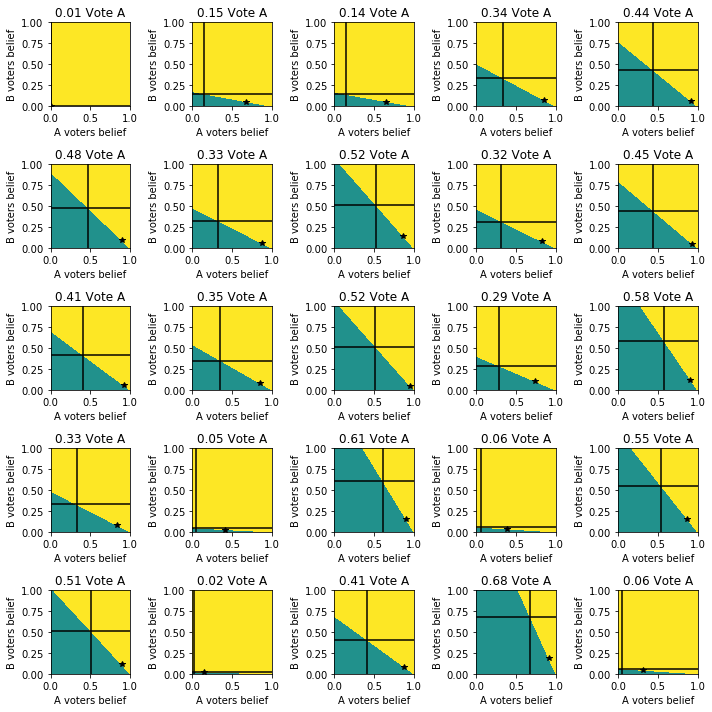

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup(WS_p=np.random.uniform(0,.3), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4), a=10)
    g = simulate(g, max_rounds=10)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

Perhaps this is a function of the WS network? Using a powerlaw cluster graph gives distinctly off-threshold results.

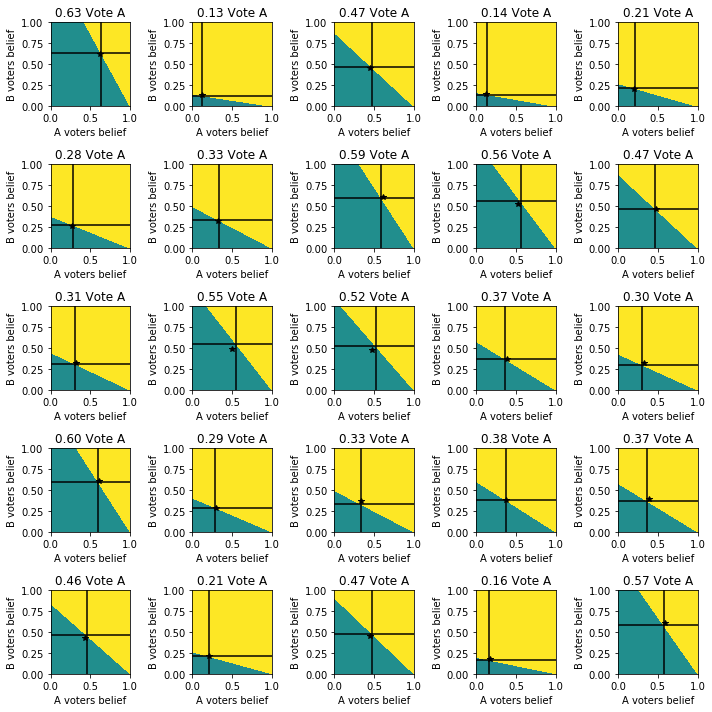

In [81]:
def setup2(n_voters=1000, WS_k=6, WS_p=.1,
          f_know=.1,  # what fraction of the population is given the ground truth
          initial_bias_towards=.3,  # for the remaining (uninformed) population, how likely are they to believe?
          a=0, # how much should knowledge be clustered? 0 is uniform dist...
          b=0,
         ):
    np.random.seed()
    g = nx.nx.powerlaw_cluster_graph(n_voters, WS_k, WS_p)
    
    #cluster knowledge
    x = np.linspace(0,1,n_voters)
    y = x**a * (1-x)**b
    ps = y/sum(y)
    
    knowers = np.random.choice(range(n_voters), size=int(n_voters*f_know), replace=False, p=ps)
    have_info = [1 if i in knowers else 0 for i in range(n_voters) ]
    nx.set_node_attributes(g, name='informed', values={n:i for n, i in enumerate(have_info)})

    believe = where(have_info, 1, np.random.binomial(1, initial_bias_towards, n_voters))
    nx.set_node_attributes(g, name='believe', values={n:i for n, i in enumerate(believe)})

    return g


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup2(WS_p=np.random.uniform(.6,1), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4))
    g = simulate(g, max_rounds=0)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

The powerlaw distribution means we are more likely to converge to unanimity, which means A as we fix some individuals: 

Converged at 1.00 after 6 rounds


/Users/houghton/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/houghton/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Converged at 1.00 after 6 rounds
Converged at 1.00 after 4 rounds
Converged at 1.00 after 4 rounds
Converged at 1.00 after 4 rounds
Converged at 0.10 after 3 rounds
Converged at 0.10 after 3 rounds
Converged at 1.00 after 4 rounds
Converged at 0.00 after 2 rounds
Converged at 0.08 after 4 rounds
Converged at 1.00 after 3 rounds
Converged at 0.11 after 3 rounds
Converged at 0.47 after 5 rounds
Converged at 0.29 after 4 rounds
Converged at 1.00 after 5 rounds
Converged at 1.00 after 3 rounds
Converged at 0.10 after 4 rounds
Converged at 0.38 after 6 rounds
Converged at 0.31 after 4 rounds
Converged at 0.24 after 3 rounds
Converged at 1.00 after 5 rounds
Converged at 0.28 after 4 rounds
Converged at 0.35 after 5 rounds
Converged at 0.19 after 2 rounds


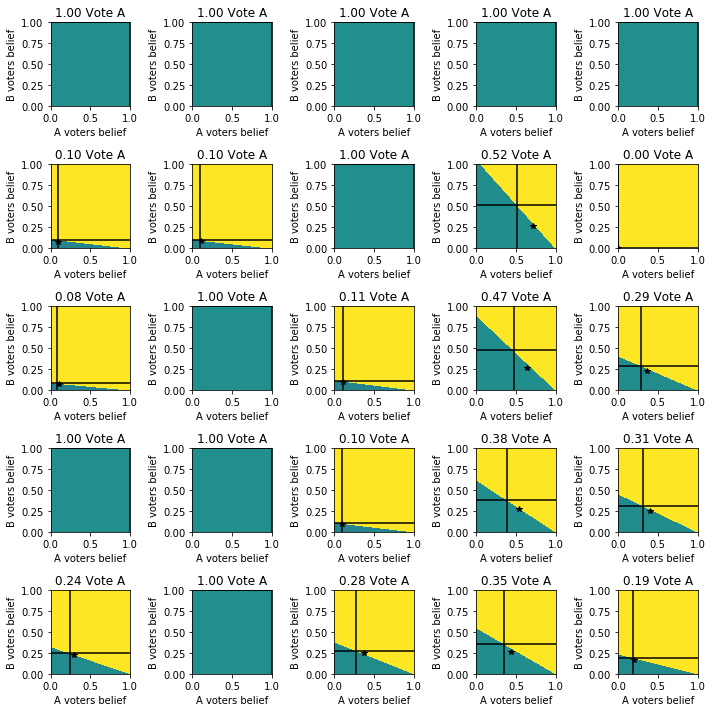

In [62]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup2(WS_p=np.random.uniform(.6,1), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4))
    g = simulate(g, max_rounds=10)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

If we cluster the information in the initial nodes - that is the better connected ones, then the algorithm seems more likely to be wrong.

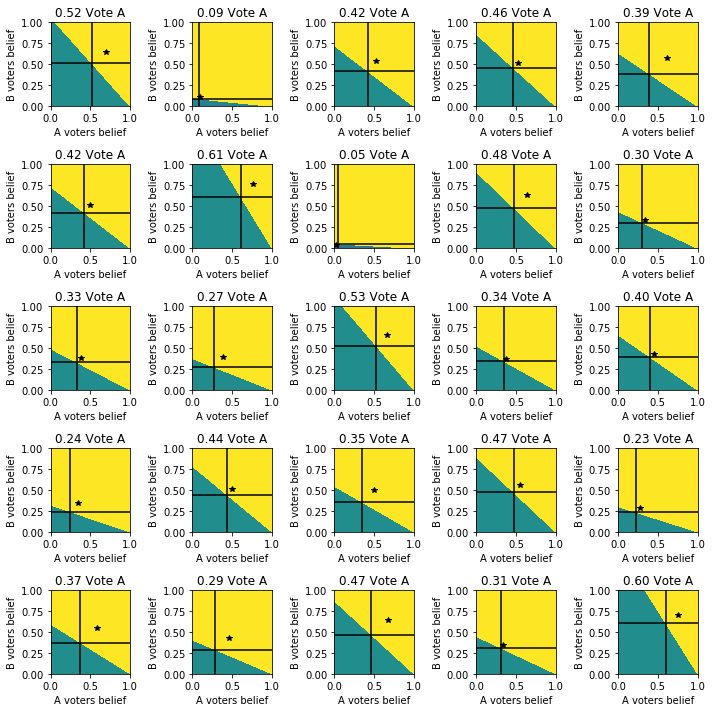

In [63]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup2(WS_p=np.random.uniform(.6,1), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4), b=3)
    g = simulate(g, max_rounds=0)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

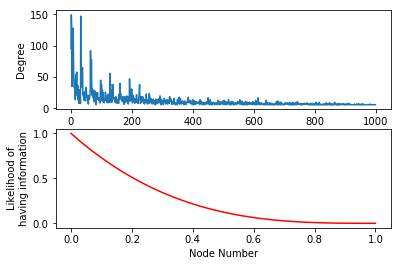

In [79]:
a = 0,
b = 3
plt.subplot(2,1,1)
plt.plot(g, list(dict(nx.degree(g)).values()))

plt.ylabel('Degree')

x = np.linspace(0,1,n_voters)
y = x**a * (1-x)**b
plt.subplot(2,1,2)
plt.plot(x, y, 'r')
plt.xlabel('Node Number')
plt.ylabel('Likelihood of\nhaving information');

When we give the information to the low degree people, the algorithm is more likely to be correct.

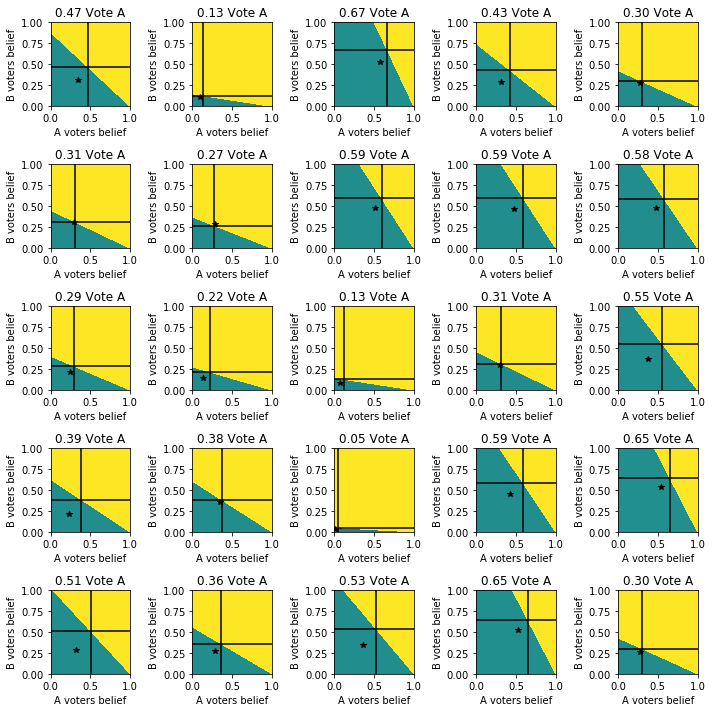

In [64]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    g = setup2(WS_p=np.random.uniform(.6,1), 
              f_know=np.random.uniform(0,.5), 
              initial_bias_towards=np.random.uniform(0,.4), a=3)
    g = simulate(g, max_rounds=0)
    f_A, A_f_A, B_f_A = measure(g)
    
    plot(f_A, A_f_A, B_f_A)
    
plt.tight_layout()

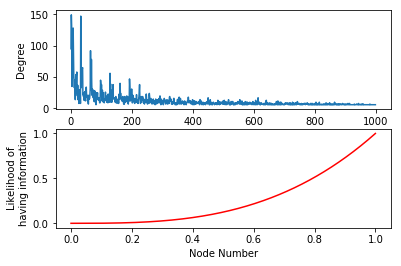

In [80]:
a = 3
b = 0
plt.subplot(2,1,1)
plt.plot(g, list(dict(nx.degree(g)).values()))

plt.ylabel('Degree')

x = np.linspace(0,1,n_voters)
y = x**a * (1-x)**b
plt.subplot(2,1,2)
plt.plot(x, y, 'r')
plt.xlabel('Node Number')
plt.ylabel('Likelihood of\nhaving information');

## Conclusion

If individuals form their estimates of the number of people who will vote for an option as a function of what their neighbors say, then the network structure, and the connectedness of the individuals receiving ground truth matters to the success of the algorithm.